# Exercise 1: Classifying penguin species with PyTorch

<img src="https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png" width="750" />


Artwork by @allison_horst

In this exercise, we will use the python package [``palmerpenguins``](https://github.com/mcnakhaee/palmerpenguins) to supply a toy dataset containing various features and measurements of penguins.

We have already created a PyTorch dataset which yields data for each of the penguins, but first we should examine the dataset and see what it contains.

### Task 1 -- Part (a): Look at the data
In the following code block, we import the ``load_penguins`` function from the ``palmerpenguins`` package.

- Call this function, which returns a single object, and assign it to the variable ``data``.
  - Print ``data`` and recognise that ``load_penguins`` has returned a ``pandas.DataFrame``.
- Consider which features it might make sense to use in order to classify the species of the penguins.
  - You can print the column titles using ``pd.DataFrame.keys()``
  - You can also obtain useful information using ``pd.DataFrame.Series.describe()``

In [2]:
from palmerpenguins import load_penguins

data = load_penguins()

# Note: ``pd.DataFrame.describe`` is a useful function for giving an overview
# of what a ``pd.DataFrame`` contains.
print(data.describe())

print(data.keys())

print(data["species"].value_counts(dropna=True))

data.head()

       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
count      342.000000     342.000000         342.000000   342.000000   
mean        43.921930      17.151170         200.915205  4201.754386   
std          5.459584       1.974793          14.061714   801.954536   
min         32.100000      13.100000         172.000000  2700.000000   
25%         39.225000      15.600000         190.000000  3550.000000   
50%         44.450000      17.300000         197.000000  4050.000000   
75%         48.500000      18.700000         213.000000  4750.000000   
max         59.600000      21.500000         231.000000  6300.000000   

              year  
count   344.000000  
mean   2008.029070  
std       0.818356  
min    2007.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2009.000000  
Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')
species
Adelie    

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/man/figures/culmen_depth.png" width="500" />
</div>

### Task 1 -- Part (b): Use seaborn to plot the distribution of the penguin species in the dataset.

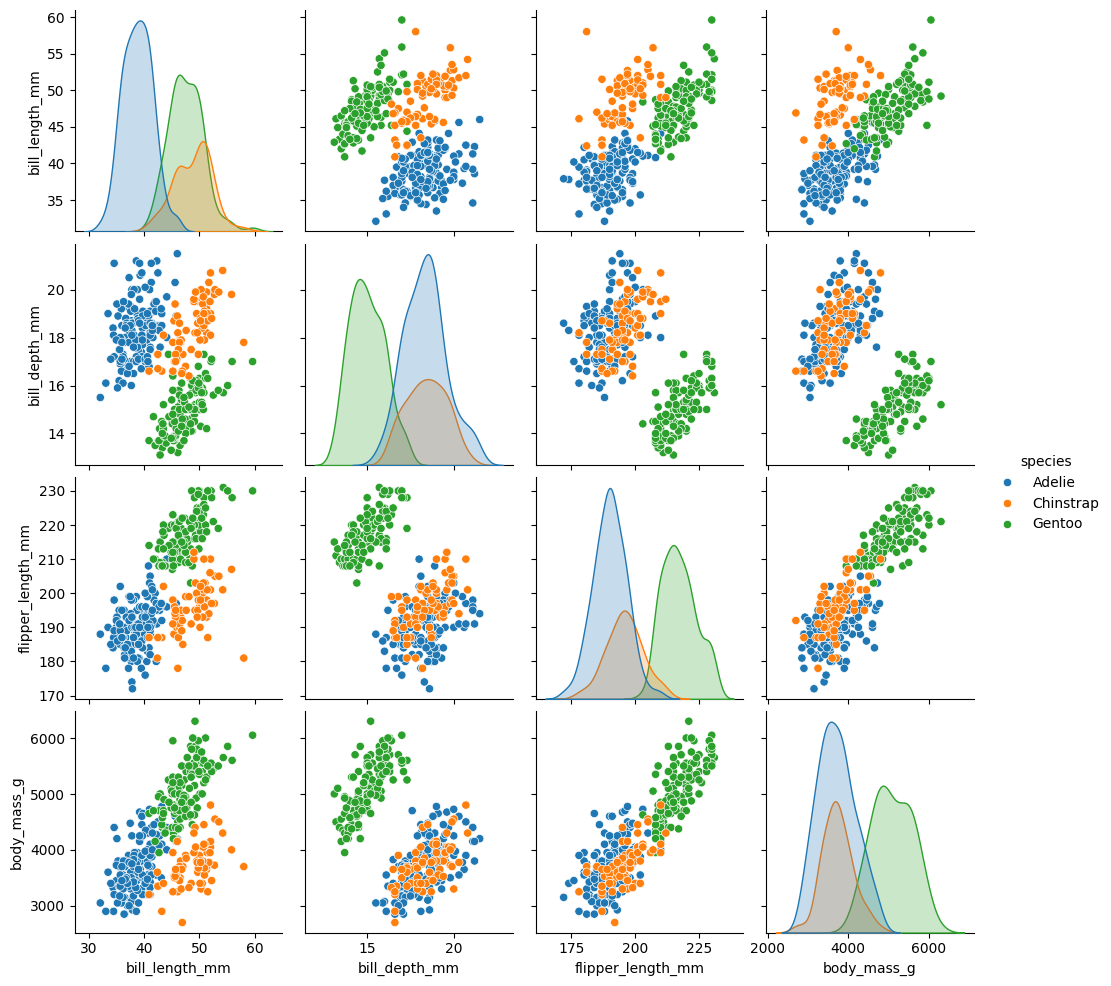

In [7]:
import seaborn as sns

species_palette = {
    "Adelie": sns.color_palette()[0],     # Blue
    "Chinstrap": sns.color_palette()[1],  # Orange
    "Gentoo": sns.color_palette()[2],     # Green
}

sns.pairplot(
    data.drop("year", axis=1),
    hue="species",
    palette=species_palette,
    hue_order=["Adelie", "Chinstrap", "Gentoo"],  # optional but ensures order
)

Let's now discuss the features we will use to classify the penguins' species, and populate the following list together:

#### Let's use:

- ``"bill_length_mm"``
    - Biologically relevant and unambiguous.
- ``"bill_depth_mm"``
    - Biologically relevant.
- ``flipper_length_mm``
    - Biologically relevant.
- ``"body_mass_g"``
    - Biologically relevant.
- ``"sex"``
    - While a potential source of bias, it is likely informative and biologically relevant.

#### Let's reject
- ``"island"``
    - While island is likely to be predictive, it seems potentially misleading to use this feature. One island could be heavily dominated by one species of penguin, while other species abide there in much smaller numbers. Such a situation could result in a model giving too much weight to this feature, and confounding the results.
- ``"year"``
    - This feature could also be important: then behaviour of certain species may be changing in response to time-dependent environmental factors such as melting ice. It does however seem like the least biologically-relevant feature, and the most likely source of bias, so we reject it.

### Task 1 -- Part (c): Apply umap to visualise the data

/Users/matt/miniforge3/envs/ml-workshop/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


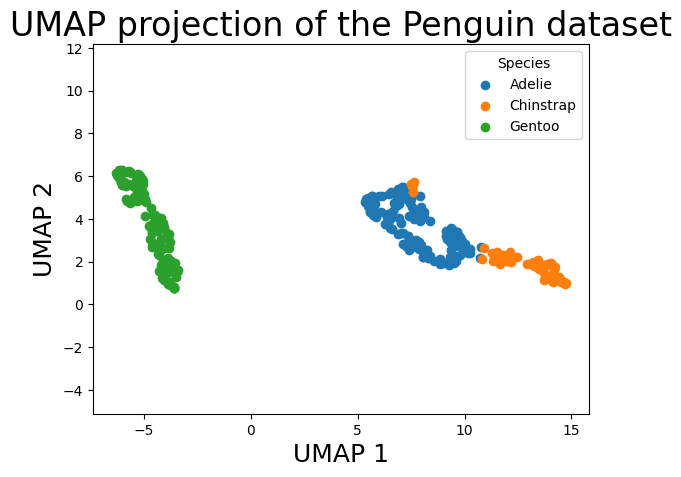

In [6]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Drop rows with missing values
data = data.dropna()  

# Extract features
penguin_data = data[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values 
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

# Fit and transform
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(scaled_penguin_data)

for i, (species, group) in enumerate(data.groupby("species")):
    plt.scatter(
        embedding[data.species == species, 0],
        embedding[data.species == species, 1],
        label=species,
        color=species_palette[species],
    )

plt.gca().set_aspect("equal", "datalim")
plt.title("UMAP projection of the Penguin dataset", fontsize=24)
plt.xlabel("UMAP 1", fontsize=18)
plt.ylabel("UMAP 2", fontsize=18)
plt.legend(loc="upper right", fontsize=10, title="Species")
plt.show()

### Task 2: Creating a ``torch.utils.data.Dataset``

The penguin data reading and processing can be encapsulated in a PyTorch dataset class.

- Why is a class representation helpful?
  - Modularity - Separation of concerns makes the code easier to understand, maintain and test.
  - Maintainability - Changes are localised, therefore we only need to change a single file to update. 
  - Abstraction - Users do not need to know how the data is read or processed, they only need to know how to interact with the class. 

All PyTorch dataset objects are subclasses of the ``torch.utils.data.Dataset`` class. To make a custom dataset, create a class which inherits from the ``Dataset`` class, implement some methods (the Python magic (or dunder) methods ``__len__`` and ``__getitem__``) and supply some data.

Spoiler alert: we've done this for you already below (see ``src/ml_workshop/_penguins.py`` for a more sophisticated implementation)

- Open the file ``src/ml_workshop/_penguins.py``.
- Let's examine, and discuss, each of the methods together.
  - ``__len__``
    - What does the ``__len__`` method do?
      - The ``__len__`` method is a so-called "magic method", which tells python to do if the ``len`` function is called on the object containing it.
  - ``__getitem__``
    - What does the ``__getitem__`` method do?
      - The ``__getitem__`` method is another magic method which tells python what to do if we try and index the object containing it (i.e. ``my_object[idx]``).
- Review and discuss the class arguments.
  - ``input_keys``— A sequence of strings telling the data set which objects to return as inputs to the model.
  - ``target_key``— Same as ``input_keys`` but specifying the target.
  - ``train``— A boolean variable determining if the model returns the training or validation split (``True`` for training).

In [ ]:
from typing import List, Tuple, Any

# import some useful functions here, see https://pytorch.org/docs/stable/torch.html
# where `tensor` is used for constructing tensors,
# and using a lower-precision float32 is advised for performance
# Task 4: add imports here
from torch import tensor, float32, long

from torch.utils.data import Dataset

from palmerpenguins import load_penguins


class PenguinDataset(Dataset):
    """Penguin dataset class.

    Parameters
    ----------
    input_keys : List[str]
        The column titles to use in the input feature vectors.
    target_key : str
        The column titles to use in the target feature vectors.
    train : bool
        If ``True``, this object will serve as the training set, and if
        ``False``, the validation set.

    Notes
    -----
    The validation split contains 10 male and 10 female penguins of each
    species.

    """

    def __init__(
        self,
        input_keys: List[str],
        target_key: str,
        train: bool,
    ):
        """Build ``PenguinDataset``."""
        self.input_keys = input_keys
        self.target_key = target_key

        data = load_penguins()
        data = (
            data.loc[~data.isna().any(axis=1)]
            .sort_values(by=sorted(data.keys()))
            .reset_index(drop=True)
        )
        # Transform the sex field into a float, with male represented by 1.0, female by 0.0
        data.sex = (data.sex == "male").astype(float)
        self.full_df = data

        valid_df = self.full_df.groupby(by=["species", "sex"]).sample(
            n=10,
            random_state=123,
        )
        # The training items are simply the items *not* in the valid split
        train_df = self.full_df.loc[~self.full_df.index.isin(valid_df.index)]

        self.split = {"train": train_df, "valid": valid_df}[
            "train" if train is True else "valid"
        ]

        # Build label map from the full dataset
        unique_labels = sorted(self.full_df[self.target_key].unique())
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self) -> int:
        """Return the length of requested split.

        Returns
        -------
        int
            The number of items in the dataset.

        """
        return len(self.split)

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        """Return an input-target pair.

        Parameters
        ----------
        idx : int
            Index of the input-target pair to return.

        Returns
        -------
        in_feats : Any
            Inputs.
        target : Any
            Targets.

        """
        # get the row index (idx) from the dataframe and
        # select relevant column features (provided as input_keys)
        feats = tuple(self.split.iloc[idx][self.input_keys])

        # this gives a 'species' i.e. one of ('Gentoo',), ('Chinstrap',), or ('Adelie',)
        tgt = self.split.iloc[idx][self.target_key]

        # Task 4 -- Part (a): Convert the tuple features to PyTorch Tensors
        feats = tensor(feats, dtype=float32)

        # Task 4 -- Part (b): Convert the target (a Python integer) to a 0-D tensor (scalar tensor).
        tgt = tensor(self.label_map[tgt], dtype=long)
        return feats, tgt

### Task 3: Obtaining training and validation datasets

- Instantiate the penguin dataloader.
  - Make sure you supply the correct column titles for the features and the targets.
- Then iterate over the dataset

In [5]:
features = [
    "bill_length_mm",
    "bill_depth_mm",
    "body_mass_g",
    "flipper_length_mm",
    "sex",
]

target_names = sorted(data.species.unique())

data_set = PenguinDataset(
    input_keys=features,
    target_key="species",
    train=True,
)

for _, (input_feats, target) in zip(range(20), data_set):
    print(input_feats, target)

tensor([  42.9000,   13.1000, 5000.0000,  215.0000,    0.0000]) tensor(2)
tensor([  46.1000,   13.2000, 4500.0000,  211.0000,    0.0000]) tensor(2)
tensor([  44.9000,   13.3000, 5100.0000,  213.0000,    0.0000]) tensor(2)
tensor([  43.3000,   13.4000, 4400.0000,  209.0000,    0.0000]) tensor(2)
tensor([  42.0000,   13.5000, 4150.0000,  210.0000,    0.0000]) tensor(2)
tensor([  46.5000,   13.5000, 4550.0000,  210.0000,    0.0000]) tensor(2)
tensor([  44.0000,   13.6000, 4350.0000,  208.0000,    0.0000]) tensor(2)
tensor([  40.9000,   13.7000, 4650.0000,  214.0000,    0.0000]) tensor(2)
tensor([  42.6000,   13.7000, 4950.0000,  213.0000,    0.0000]) tensor(2)
tensor([  42.7000,   13.7000, 3950.0000,  208.0000,    0.0000]) tensor(2)
tensor([  45.3000,   13.7000, 4300.0000,  210.0000,    0.0000]) tensor(2)
tensor([  47.2000,   13.7000, 4925.0000,  214.0000,    0.0000]) tensor(2)
tensor([  45.2000,   13.8000, 4750.0000,  215.0000,    0.0000]) tensor(2)
tensor([  43.6000,   13.9000, 4900.000

* Can we give these items to a neural network, or do they need to be transformed first?
  + Short answer: no, we can't just pass tuples of numbers or strings to a neural network.
    - We must represent these data as ``torch.Tensor``s. This is the fundamental data abstraction used by PyTorch; they are the PyTorch equivalent to Numpy arrays. See [pytorch tensors documentation](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) . 
    - The targets are tuples of strings i.e. ('Gentoo', )
      - One idea is to represent as categorical indices i.e.  [1] or [2] or [3]. Will this work? 

### Task 4 -- Part (a) and (b): Convert Dataset objects to PyTorch Tensors. 

Modify the `PenguinDataset` class above so that the tuples of numbers are converted to PyTorch `torch.Tensor` s and the string targets are converted to indices.

- Begin by importing relevant PyTorch functions.
- Complete the `__getitem__()` function above.

Then create a training and validation set.

  - We allow the model to learn directly from the training set—i.e. we fit the function to these data.
  - During training, we monitor the model's performance on the validation set in order to check how it's doing on unseen data. Normally, people use the validation performance to determine when to stop the training process.
  
For the validation set, we choose ten males and ten females of each species. This means the validation set is less likely to be biased by sex and species, and is potentially a more reliable measure of performance. You should always be _very_ careful when choosing metrics and splitting data.

- Is this solution general?
  - No. The transformations have been hardcoded. A more flexible way of transforming inputs to neural networks is to apply a series of transforms using `torchvision.transforms.Compose`. The [ `Compose` ](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html) object takes a list of callable objects and applies them to the incoming data. See how this is done more generally in the `src/ml_workshop/_penguins.py` file. 

These transforms can be very useful for mapping between file paths and tensors of images, etc.

In [ ]:
# Apply transforms we need to PenguinDataset to convert input data and target class to tensors.
# See Task 4 ``TODOs`` comments above.


# Create train_set
train_set = PenguinDataset(
    input_keys=features,
    target_key="species",
    train=True,
)

# Create valid_set
valid_set = PenguinDataset(
    input_keys=features,
    target_key="species",
    train=False,
)


for _, (input_feats, target) in zip(range(5), train_set):
    print(input_feats, target)

tensor([  42.9000,   13.1000, 5000.0000,  215.0000,    0.0000]) tensor(2)
tensor([  46.1000,   13.2000, 4500.0000,  211.0000,    0.0000]) tensor(2)
tensor([  44.9000,   13.3000, 5100.0000,  213.0000,    0.0000]) tensor(2)
tensor([  43.3000,   13.4000, 4400.0000,  209.0000,    0.0000]) tensor(2)
tensor([  42.0000,   13.5000, 4150.0000,  210.0000,    0.0000]) tensor(2)


### (Optional) Task 4 -- Part (c): `torchvision.transforms.Compose`

<details>
<summary>Transforming inputs: An idiomatic approach </summary>

A common way of transforming inputs to neural networks is to apply a series of transforms using `torchvision.transforms.Compose`. The [ `Compose` ](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html) object takes a list of callable objects and applies them to the incoming data. 

One flaw of the current implementation is that the transformations are hardcoded inside the `PenguinDataset` class, specifically in the `__getitem__` method, rather than being passed as arguments. This makes the class less general and less reusable.

A more idiomatic approach in PyTorch would allow the `transform` (and optionally `target_transform`) to be passed in during initialization. This gives users more flexibility to adjust preprocessing pipelines for different use cases like training vs. validation or different model types.

See how this is done more generally in the [src/ml_workshop/_penguins.py](../src/ml_workshop/_penguins.py) file. 

These transformations are especially useful for tasks like converting file paths to image tensors, normalization, data augmentation, and more.


</details>

Instantiate the `torchvision.transforms.Compose` transformations and pass to the `PenguinsDataset` in [src/ml_workshop/_penguins.py](../src/ml_workshop/_penguins.py), instead of hardcoding as above. 

In [7]:
from torchvision.transforms import Compose

from ml_workshop import PenguinDataset

# import some useful functions here, see https://pytorch.org/docs/stable/torch.html
# where `tensor` and `eye` are used for constructing tensors,
# and using a lower-precision float32 is advised for performance
from torch import tensor, float32, long


# Apply the transforms we need to the PenguinDataset to get out input
# targets as Tensors.


def get_input_transforms() -> Compose:
    """Return transforms which map from raw inputs to tensors.

    Returns
    -------
    Compose
        A composition of transforms (callable functions) to map the tuple
        of input features (``Tuple[float, ...]``) to a ``torch.Tensor``.

    Notes
    -----
    To create a ``torch.Tensor`` we can use ``torch.tensor([1.0, 2.0, ...])``

    """
    return Compose([lambda x: tensor(x, dtype=float32)])


def get_target_tfms() -> Compose:
    """Return transforms which map from the raw target strings to tensor.

    Returns
    -------
    Compose
        A composition of transforms (callable functions) to map the tuple
        of input features (``Tuple[str]``) to a ``torch.Tensor``.
    """
    return Compose([lambda x: tensor(target_names.index(x[0]), dtype=long)])


train_set_compose = PenguinDataset(
    input_keys=features,
    target_keys=["species"],
    train=True,
    x_tfms=get_input_transforms(),
    y_tfms=get_target_tfms(),
)


valid_set_compose = PenguinDataset(
    input_keys=features,
    target_keys=["species"],
    train=False,
    x_tfms=get_input_transforms(),
    y_tfms=get_target_tfms(),
)


for _, (input_feats, target) in zip(range(5), train_set_compose):
    print(input_feats, target)

tensor([  42.9000,   13.1000, 5000.0000,  215.0000,    0.0000]) tensor(2)
tensor([  46.1000,   13.2000, 4500.0000,  211.0000,    0.0000]) tensor(2)
tensor([  44.9000,   13.3000, 5100.0000,  213.0000,    0.0000]) tensor(2)
tensor([  43.3000,   13.4000, 4400.0000,  209.0000,    0.0000]) tensor(2)
tensor([  42.0000,   13.5000, 4150.0000,  210.0000,    0.0000]) tensor(2)


### Task 5: Creating ``DataLoaders``—and why

Once we have created a ``Dataset`` object, we wrap it in a ``DataLoader``. This comes with a number of useful features:
#### Mini-batches
The ``DataLoader`` object allows us to put our inputs and targets in **mini-batches**, which makes for more efficient training.
- Note: rather than supplying one input-target pair to the model at a time, we supply "mini-batches" of these data at once (typically a small power of 2, like 16 or 32).
- The number of items we supply at once is called the `batch size`.
> **Q:** What number should we choose for the batch size?
 
#### Shuffling
The ``DataLoader`` can also randomly **shuffle** the data each epoch (when training). 
- This avoids unwanted patterns in the data harming the fitting process. Consider providing lots of the positive class followed by the negative class, the network will only learn by saying yes all the time. Therefore need to intersperse positives and negatives.

#### Parallel loading
The ``DataLoader`` also allows **parallel loading** of mini-batches.
- This setup is especially useful for large datasets or image files that can't all be loaded into memory at once. The DataLoader loads data in small batches as needed, and using multiple workers allows this to happen in parallel with model training—improving overall speed.

<details>
<summary><strong>Why do we need a DataLoader?</strong></summary>
<p>
The <code>DataLoader</code> is a PyTorch utility that provides an iterable over the dataset, allowing us to easily access mini-batches of data. It handles batching, shuffling, and parallel loading of the data, which is essential for efficient training of neural networks.
</p>
</details>

<details>
<summary><strong>Note on batch normalisation</strong></summary>
<p>
We are going to use batch normalisation layers in our network, which won't work if the batch size is one. This can happen on the last batch, if we don't choose a batch size that evenly divides the number of items in the dataset. To avoid this, we can set the <code>drop_last</code> argument to <code>True</code>. The last batch, which will be of size <code>len(data_set) % batch_size</code>, gets dropped, and the data are reshuffled. This is only relevant during the training process — validation will use population statistics.
</p>
</details>

In [8]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
)

for batch, targets in valid_loader:
    print(batch.shape, targets.shape)

torch.Size([16, 5]) torch.Size([16])
torch.Size([16, 5]) torch.Size([16])
torch.Size([16, 5]) torch.Size([16])
torch.Size([12, 5]) torch.Size([12])


### Task 6 -- Part (a): Creating a neural network in PyTorch
Here we will create our neural network in PyTorch, and have a general discussion on clean and messy ways of going about it.

The module `torch.nn` contains different classes that help you build neural network models. All models in PyTorch inherit from the subclass `nn.Module`, which has useful methods like `parameters()`, `__call__()`, and others.

`torch.nn` also has various layers that you can use to build your neural network. For example, we will use `nn.Linear` in our code below, which constructs a fully connected layer. `torch.nn.Linear` is a subclass of `torch.nn.Module`.

What exactly is a "layer"? It is essentially a step in the neural network computation. For example, the `nn.Linear` layer computes the linear transformation of the input vector $x$:

$$
y = W^T x + b
$$

where $W$ is the matrix of tunable parameters and $b$ is a bias vector.

We can also think of the ReLU activation as a "layer". However, there are no tunable parameters associated with the ReLU activation function.

The `__init__()` method is where we typically define the attributes of a class. In our case, all the "sub-components" of our model should be defined here.

The `forward` method is called when we use the neural network to make a prediction. Another term for "making a prediction" is **running the forward pass**, because information flows forward from the input through the hidden layers to the output. This builds a computational graph.

The `forward` method is called from the `__call__()` function of `nn.Module`, so that when we run `model(batch)`, the `forward` method is called.

### Summary of what we will do:
- First, we will create quite an **ugly network** to highlight how to make a neural network in PyTorch at a very basic level.
- We will then utilise `torch.nn.Sequential` as a **neater approach**.
- Finally, we will discuss how the **best approach** would be to write a class where various parameters (e.g. number of layers, dropout probabilities, etc.) are passed as arguments.

In [9]:
from torch.nn import Module
from torch.nn import BatchNorm1d, Linear, LeakyReLU, Dropout, Sequential
from torch import Tensor


class FCNet(Module):
    """Fully-connected neural network.

    Parameters
    ----------
    in_feats : int
        The number of input features to the model.
    out_feats : int
        The number of output features (or classes) the model should produce.

    Notes
    -----
    The ``torch.nn.Sequential`` class allows us to "chain" multiple layers, rather
    than manually passing the output of one to the next in the forward
    function.

    """

    def __init__(self, in_feats: int, out_feats: int):
        """Build the neural network."""
        super().__init__()
        self._fwd_seq = Sequential(
            BatchNorm1d(in_feats),
            Linear(in_feats, 16),
            BatchNorm1d(16),
            Dropout(0.1),
            LeakyReLU(0.1),
            Linear(16, 16),
            BatchNorm1d(16),
            Dropout(0.1),
            LeakyReLU(0.1),
            Linear(16, out_feats),
        )

    def forward(self, batch: Tensor) -> Tensor:
        """Pass ``batch`` through the model.

        Parameters
        ----------
        batch : Tensor
            A mini-batch of inputs.

        Returns
        -------
        Tensor
            The result of passing ``batch`` through the model.

        """
        return self._fwd_seq(batch)


model = FCNet(len(features), len(target_names))
print(model)

FCNet(
  (_fwd_seq): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Linear(in_features=16, out_features=16, bias=True)
    (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Linear(in_features=16, out_features=3, bias=True)
  )
)


### (Optional) Task 6 -- Part (b): Import ResNet50 weights

Have a go at importing the model weights for a large model like ResNet50


In [10]:
# Import ResNet50 here
from torchvision.models import resnet50

# Create a ResNet50 model and print it.
res_model = resnet50(pretrained=True)
# Set the model to evaluation mode.
res_model.eval()
# Print the model architecture.
# print(res_model)

# list(res_model.parameters())

/Users/matt/miniforge3/envs/ml-workshop/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/matt/miniforge3/envs/ml-workshop/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Task 7: Selecting a loss function

- Cross-entropy is about the most common loss function for classification.
  - Details on this loss function are available in the [PyTorch docs](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
- Let's instantiate it together.

In [11]:
from torch.nn import CrossEntropyLoss

loss_func = CrossEntropyLoss()

### Task 8: Selecting an optimiser

While we talked about stochastic gradient descent in the slides, most people use the so-called [Adam optimiser](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

You can think of it as a more complex and improved implementation of SGD.

Here we will tell the optimiser what parameters to fit in order to minimise the loss. 

In [12]:
# Create an optimiser and give it the model's parameters.
from torch.optim import Adam

optimiser = Adam(model.parameters())

### Task 9: Writing basic training and validation loops

####  Applying an activation function to model outputs

Our model produces raw scores, called **logits**. These are unnormalized and can be positive or negative. On their own, logits are not directly interpretable.

To make sense of these outputs (e.g., “how confident is the model?”), we apply an **activation function** like `softmax`, which converts logits into **pseudo-probabilities**.

> **Important:** We do **not** apply this activation inside the model or during
> training. The loss function we’re using (`CrossEntropyLoss`) expects **raw logits** and handles this internally.  
> We only apply `softmax` **after training**, for tasks like evaluation or
> visualization.

In general, we don’t usually include the output activation function in the network itself because it’s often handled more efficiently and flexibly by the loss function. Keeping it separate makes it easier to swap in different losses or interpret raw logits directly during training and debugging.

<details>
<summary>Why softmax? And what’s this about thermodynamics?</summary>

- According to the
  [PyTorch documentation on `CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html),
  this loss combines `LogSoftmax` and `NLLLoss` into a single function — so we
  don’t need to apply softmax ourselves during training.
- [Documentation on `nn.Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
  shows that it's appropriate when the prediction should be **exactly one of**
  the possible classes — like species `Adelie`, `Chinstrap`, or `Gentoo`.

### What does softmax do?

Softmax turns logits into probabilities — it's what lets us say "the model is 90% confident it's a penguin of species `Adelie`."

### Physics connection

If you’ve studied physics, it might remind you of the **partition function** in thermodynamics — softmax turns logits into a normalised probability distribution, just as a partition function normalises energy states.  This analogy appears in several places in machine learning under names like "temperature scaling" and "energy-based models".

### When not to use softmax?
This activation is **not appropriate** if you want to assign **multiple labels** to the same input (e.g. both "dog" _and_ "cat").

### Final note on softmax and argmax
Since softmax is **monotonic** (it preserves order), using `argmax` on logits gives the same result as `argmax` on softmax probabilities.  
That’s why we don’t need to apply softmax just to get the predicted class.
</details>

---

### Part (a) -- training and validation loops

Have a go at writing the training and evaluation loops. Use the tips below to guide you.

#### Tips

- Configure the model separately for **training** and **validation**.
- Don't worry about storing metrics just yet, focus on the training and validation loops.
- Try to get it training first before implementing the validation loop. We will guide you through this process. 

<details>
<summary>How does the loss **know** about parameters in the model? </summary>

- PyTorch tensors can track operations when `requires_grad=True`.
- When we run the **forward pass** (`preds = model(batch)`), PyTorch builds a **dynamic computation graph** that records all operations, including how the model's parameters were used to compute the predictions.
- The **loss** (`loss = criterion(preds, targets)`) depends on the predictions, so it's also connected to the model parameters via this graph.
- Calling `loss.backward()` performs the **backward pass**, where PyTorch:
  - Traverses the computation graph,
  - Computes gradients of the loss w.r.t. each parameter that requires gradients.

> `loss.backward()` **computes gradients but does not update** parameters. You need to call `optimizer.step()` to apply the updates.

Because PyTorch uses a **dynamic graph**, the graph is recreated on every forward pass, making it flexible and easy to debug.


</details>

<details>
<summary>PyTorch Autograd and <code>requires_grad</code></summary>

**NOTE:** In PyTorch, `requires_grad=True` is set automatically for the parameters of layers defined using `torch.nn.Module` subclasses.

Here’s a simple example:

```python
x = ones(10, requires_grad=True)
y = 2 * x.exp()
print(y)
```
</details>

<details>
<summary>Don't forget: Optimizer accumulates gradients</summary>

By default, PyTorch accumulates gradients each time you call `loss.backward()`.  
You must reset them manually with `optimizer.zero_grad()` before each training step.

</details>

<details>
<summary>Evaluation tip: Disable gradients</summary>

Use the decorator  `@no_grad()` or context `with no_grad():` during evaluation or inference.  
This saves memory and speeds things up by skipping gradient tracking.

</details>

---

### Part (b) -- tracking metrics

To track training and validation progress, follow these steps:

- Define a dictionary:
  ```python
  metrics = {"loss": [], "accuracy": []}
  ```

- Append the loss using `loss.item()` (it's a scalar; no gradients needed).

- Write a function `get_batch_accuracy(preds: Tensor, targets: Tensor)`.

- We need to supply the metrics as `means` over each epoch.
 <details>
 <summary> More on metrics structure</summary>

 The metrics should be a dictionary containing `"loss"` and `"accuracy"` as keys and lists as values which we append to during each iteration.  

 We can then use dictionary comprehension to get epoch-level statistics:
 ```python
 epoch_stats = {k: mean(v) for k, v in metrics.items()}
 ```
</details> 

<details>
<summary>Example: Summarising metrics over an epoch</summary>

```python
# i.e. for a batch_size of 3
metrics = {"loss": [1.0, 2.0, 3.0], "accuracy": [0.7, 0.8, 0.9]}
epoch_stats = {k: mean(v) for k, v in metrics.items()}
```
</details> <details> <summary>Over-fitting warning</summary>

If the validation performance gets significantly worse while training performance improves, it’s a sign of over-fitting.

</details> 


In [13]:
from typing import Dict, List

from numpy import mean

from torch import no_grad


def train_one_epoch(
    model: Module,
    train_loader: DataLoader,
    optimiser: Adam,
    loss_func: CrossEntropyLoss,
) -> Dict[str, float]:
    """Train ``model`` for once epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    train_loader : DataLoader
        Training dataloader.
    optimiser : Adam
        The optimiser.
    loss_func : CrossEntropyLoss
        Cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    Notes
    -----
    - The ``model.train()`` is very important:
        - it turns on the dropout layers.
        - it tells the batch norm layers to use the incoming
          statistics, and let them contribute to their "memory".

    """
    model.train()
    metrics: Dict[str, List[float]] = {"loss": [], "accuracy": []}

    for batch, targets in train_loader:
        optimiser.zero_grad()

        preds = model(batch)

        loss = loss_func(preds, targets)

        loss.backward()

        optimiser.step()

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_level_accuracy(preds, targets))

    return {key: float(mean(val)) for key, val in metrics.items()}


@no_grad()
def validate_one_epoch(
    model: Module,
    valid_loader: DataLoader,
    loss_func: CrossEntropyLoss,
) -> Dict[str, float]:
    """Validate ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    valid_loader : DataLoader
        Training dataloader.
    loss_func : CrossEntropyLoss
        Cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        Metrics of interest.

    Notes
    -----
    - The ``model.eval()`` is also very important:
        - It turns off the dropout layers, which are likely to impair the
          validation performance and render it unrealistically poor.
        - It tells the batchnorm layers to _not_ use the batch's statistics,
          and to instead use the stats it has built up from the training set.
          The model should not "remember" anything from the validation set.
    - We also protect this function with ``torch.no_grad()``, because having
      gradients enabled while validating is a pointless waste of
      resources — they are only needed for training.

    """
    model.eval()
    metrics: Dict[str, List[float]] = {"loss": [], "accuracy": []}

    for batch, targets in valid_loader:
        # preds = model(batch).softmax(dim=1)
        preds = model(batch)

        loss = loss_func(preds, targets)

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_level_accuracy(preds, targets))

    return {key: float(mean(val)) for key, val in metrics.items()}


@no_grad()
def batch_level_accuracy(preds: Tensor, targets: Tensor):
    """Compute the batch-level accuracy.

    Parameters
    ----------
    preds : Tensor
        The model's predictions.
    targets : Tensor
        The corresponding labels.

    Returns
    -------
    float
        The batch-level accuracy.

    Notes
    -----
    - This function assumes the ``preds`` have had the softmax
      applied to them along dimension 1, and that the predicted
      class is therefore ``preds.argmax(dim=1)``.

    """
    return (preds.argmax(dim=1) == targets).float().mean().item()

### Task 10: Training, extracting and plotting metrics

- Now we can train our model for a specified number of epochs.
  - During each epoch the model "sees" each training item once.
- Append the training and validation metrics to a list.
- Turn them into a ``pandas.DataFrame``
  - Note: You can turn a ``List[Dict{str, float}]``, say ``my_list`` into a ``DataFrame`` with ``DataFrame(my_list)``.
- Use Matplotlib to plot the training and validation metrics as a function of the number of epochs.

We will begin the code block together before you complete it independently.  
After some time we will go through the solution together.

In [14]:
from time import perf_counter

from pandas import DataFrame

epochs = 200
print_interval = 25


train_metrics, valid_metrics = [], []


for epoch in range(epochs):

    if epoch % print_interval == 0:
        if epoch != 0:
            print(
                f"Epoch {max(epoch - print_interval, 0)}-{epoch} time: {perf_counter() - tic:.6f} seconds"
            )
        tic = perf_counter()

    train_metrics.append(train_one_epoch(model, train_loader, optimiser, loss_func))

    valid_metrics.append(validate_one_epoch(model, valid_loader, loss_func))

    stop_time = perf_counter()


print("\n")

train_metrics = DataFrame(train_metrics)
valid_metrics = DataFrame(valid_metrics)

metrics = train_metrics.join(valid_metrics, lsuffix="_train", rsuffix="_valid")

print(metrics)

Epoch 0-25 time: 1.209617 seconds
Epoch 25-50 time: 1.376929 seconds
Epoch 50-75 time: 1.231316 seconds
Epoch 75-100 time: 1.482361 seconds
Epoch 100-125 time: 1.245244 seconds
Epoch 125-150 time: 0.897218 seconds
Epoch 150-175 time: 0.798195 seconds


     loss_train  accuracy_train  loss_valid  accuracy_valid
0      1.127524        0.375000    0.975563        0.421875
1      0.885884        0.588235    0.753995        0.750000
2      0.693545        0.783088    0.604292        0.890625
3      0.584849        0.863971    0.519497        0.937500
4      0.530487        0.886029    0.439309        0.968750
..          ...             ...         ...             ...
195    0.078776        0.977941    0.039941        0.984375
196    0.027427        0.988971    0.036048        0.984375
197    0.123792        0.966912    0.027662        0.984375
198    0.047308        0.981618    0.025154        0.984375
199    0.030639        0.988971    0.028674        0.984375

[200 rows x 4 columns]


### Task 11: Visualise some results

Let's do this part together—though feel free to make a start on your own if you have completed the previous exercises.

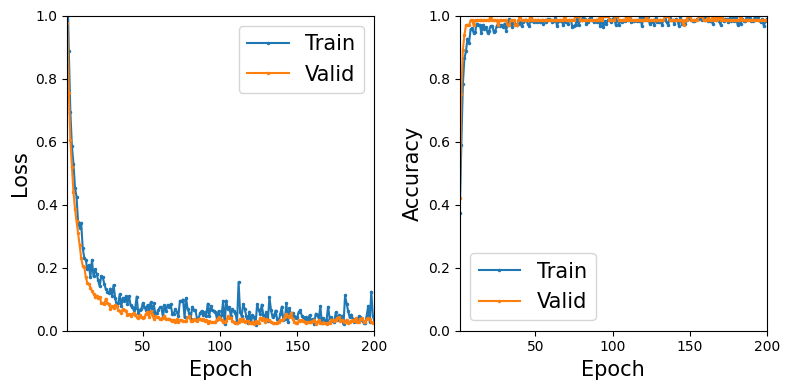

In [15]:
import matplotlib.pyplot as plt
from numpy import linspace


quantities = ["loss", "accuracy"]
splits = ["train", "valid"]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for axis, quant in zip(axes.ravel(), quantities):
    for split in splits:
        key = f"{quant}_{split}"
        axis.plot(
            linspace(1, epochs, epochs),
            metrics[key],
            "-o",
            ms=1.5,
            label=split.capitalize(),
        )
    axis.set_ylabel(quant.capitalize(), fontsize=15)

for axis in axes.ravel():
    axis.legend(fontsize=15)
    axis.set_ylim(bottom=0.0, top=1.0)
    axis.set_xlim(left=1, right=epochs)
    axis.set_xlabel("Epoch", fontsize=15)

fig.tight_layout()

### Task 12 -- Part (a): Confusion matrix

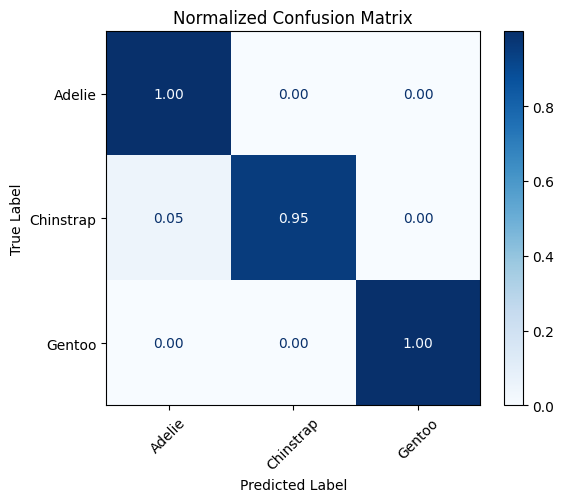

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

class_names = sorted(data.species.unique())

all_preds = []
all_labels = []

model.eval()
with no_grad():
    for batch, label in valid_loader:
        preds = model(batch).softmax(dim=1)
        all_preds.append(preds.argmax(dim=1).numpy())
        all_labels.append(label.numpy())

# concatenate all predictions and labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
cm_normalized = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, display_labels=class_names
)

# plotting
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
disp.ax_.set_xlabel("Predicted Label")
disp.ax_.set_ylabel("True Label")
plt.xticks(rotation=45)
plt.grid(False)  # cleaner plot
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

### Task 12 -- Part (b): Classification report

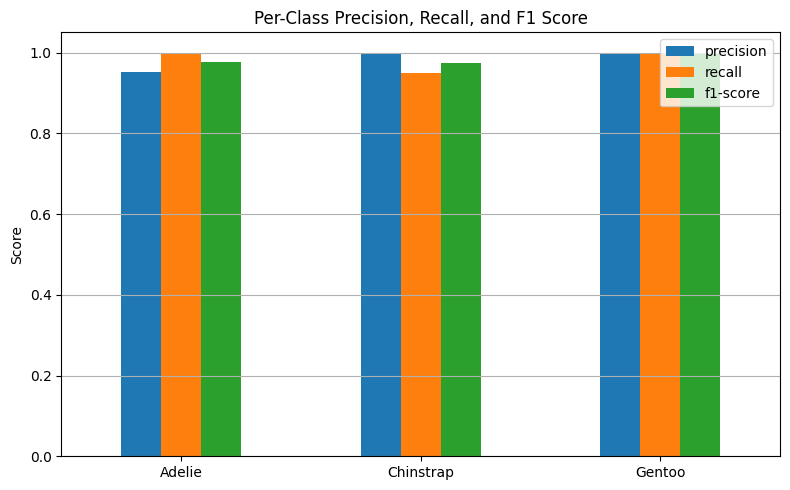

In [17]:
from sklearn.metrics import classification_report
import pandas as pd


# class_names = ['Adelie', 'Chinstrap', 'Gentoo']
report = classification_report(
    y_true=all_labels,
    y_pred=all_preds,
    target_names=class_names,
    output_dict=True  # <- so we can plot it
)


# Convert the report dict to DataFrame for plotting
report_df = pd.DataFrame(report).transpose()
report_df = report_df.loc[class_names, ['precision', 'recall', 'f1-score']]

# Plot
report_df.plot(kind='bar', figsize=(8, 5))
plt.title("Per-Class Precision, Recall, and F1 Score")
plt.ylim(0.0, 1.05)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Bonus: Run the net on 'new' inputs

We have built and trained a net, and evaluated and visualised its performance. However, how do we now utilise it going forward?

Here we construct some 'new' input data and use our trained net to infer the species. Whilst this is relatively straightforward there is still some work required to transform the outputs from the net to a meaningful result.

In [18]:
from torch import no_grad

# Construct a tensor of inputs to run the model over
demo_input = tensor(
    [
        [42.9, 13.1, 5000.0, 215.0, 0.0],
        [33.6, 11.3, 2000.0, 211.0, 1.0],
    ]
)
print(f"Raw input:\n{demo_input}\n")

# Place model in eval mode and run over inputs with no_grad
model.eval()
with no_grad():
    demo_output = model(demo_input).softmax(dim=1)

# Print the raw output from the net
print(f"Raw output:\n{demo_output}\n")

# Transform the raw output back to human-readable format
print(f"Predicted species:\n{[target_names[val.argmax()] for val in demo_output]}\n")

Raw input:
tensor([[4.2900e+01, 1.3100e+01, 5.0000e+03, 2.1500e+02, 0.0000e+00],
        [3.3600e+01, 1.1300e+01, 2.0000e+03, 2.1100e+02, 1.0000e+00]])

Raw output:
tensor([[1.3674e-07, 2.2982e-08, 1.0000e+00],
        [9.9144e-01, 4.2888e-04, 8.1314e-03]])

Predicted species:
['Gentoo', 'Adelie']

